In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Set plotting style
plt.style.use('seaborn-v0_8')

# Define path to raw data
DATA_PATH = '../data/raw/'

# Find first pair of files
msg_files = sorted(glob.glob(os.path.join(DATA_PATH, "*message*.csv")))
ob_files = sorted(glob.glob(os.path.join(DATA_PATH, "*orderbook*.csv")))

print(f"Found {len(msg_files)} message files and {len(ob_files)} orderbook files.")

if len(msg_files) > 0:
    print(f"Inspecting: {os.path.basename(msg_files[0])}")
else:
    print("WARNING: No data found! Please check data/raw/")

Matplotlib is building the font cache; this may take a moment.


Found 1 message files and 1 orderbook files.
Inspecting: AMZN_2012-06-21_34200000_57600000_message_10.csv


In [2]:
def load_lobster_day(msg_path, ob_path, level=10):
    # 1. Load Message File
    # Columns: Time (sec), Event Type, Order ID, Size, Price, Direction
    msg_df = pd.read_csv(msg_path, header=None,
                         names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'])

    # 2. Load Orderbook File
    # Columns: Ask Price 1, Ask Size 1, Bid Price 1, Bid Size 1, ...
    cols = []
    for i in range(1, level+1):
        cols.extend([f'ask_price_{i}', f'ask_size_{i}', f'bid_price_{i}', f'bid_size_{i}'])

    ob_df = pd.read_csv(ob_path, header=None, names=cols)

    # Check alignment
    assert len(msg_df) == len(ob_df), "Message and Orderbook files have different lengths!"

    # Combine
    df = pd.concat([msg_df, ob_df], axis=1)
    return df

# Load the first day
if len(msg_files) > 0:
    df = load_lobster_day(msg_files[0], ob_files[0])
    print(f"Loaded {len(df)} events.")
    display(df.head())

Loaded 269748 events.


,time,event_type,order_id,size,price,direction,ask_price_1,ask_size_1,bid_price_1,bid_size_1,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,34200.017460,5,0,1,2238200,-1,2239500,100,2231800,100,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,34200.189608,1,11885113,21,2238100,1,2239500,100,2238100,21,...,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,34200.189608,1,3911376,20,2239600,-1,2239500,100,2238100,21,...,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,34200.189608,1,11534792,100,2237500,1,2239500,100,2238100,21,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,34200.189608,1,1365373,13,2240000,-1,2239500,100,2238100,21,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


Crossed Market Events: 0 (0.0000%)
Backward Time Jumps: 0

Spread Stats:
count    269748.000000
mean       1308.616931
std         567.878899
min         100.000000
25%         900.000000
50%        1300.000000
75%        1600.000000
max        7700.000000
Name: spread, dtype: float64


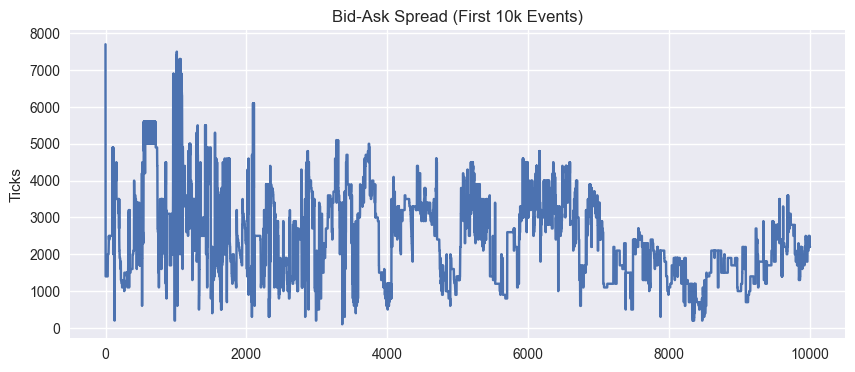

In [3]:
# 1. Check for Crossed Markets (Bid >= Ask)
# Note: LOBSTER prices are usually integers (scaled by 10,000).
# An Ask Price of 100.00 is often stored as 1000000.
crossed = df[df['bid_price_1'] >= df['ask_price_1']]
pct_crossed = len(crossed) / len(df) * 100

print(f"Crossed Market Events: {len(crossed)} ({pct_crossed:.4f}%)")
if pct_crossed > 1.0:
    print("⚠️ DANGER: High percentage of crossed markets. Data might be dirty.")

# 2. Check Monotonic Time
# Time should strictly increase or stay same. It should never go backward.
time_diff = df['time'].diff().dropna()
backward_time = time_diff[time_diff < 0]

print(f"Backward Time Jumps: {len(backward_time)}")
if len(backward_time) > 0:
    print("⚠️ DANGER: Timestamps are not monotonic!")

# 3. Check Spread Distribution
df['spread'] = df['ask_price_1'] - df['bid_price_1']
print("\nSpread Stats:")
print(df['spread'].describe())

# Plot spread
plt.figure(figsize=(10, 4))
plt.plot(df['spread'].iloc[:10000]) # Plot first 10k events
plt.title("Bid-Ask Spread (First 10k Events)")
plt.ylabel("Ticks")
plt.show()

In [4]:
print(df['event_type'].value_counts().sort_index())

event_type
1    131954
2      2917
3    123458
4      8974
5      2445
Name: count, dtype: int64
